In [1]:
from __future__ import division, absolute_import

import numpy as np

from bcn.bias import guess_func
from bcn.data import DataSimulated, estimate_partial_signal_characterists
from bcn.cost import Cost
from bcn.solvers import ConjugateGradientSolver
from bcn.linear_operators import LinearOperatorCustom, possible_measurements

import pylab as pl
import seaborn as sb

In [2]:
np.random.seed(seed=42)

In [27]:
def show_signal(signal, shuffle=False):
    indices_x = np.arange(signal.shape[0], dtype=int)
    indices_y = np.arange(signal.shape[1], dtype=int)
    fig = pl.figure(figsize=(6 * (signal.shape[1] / signal.shape[0]), 6))
    ax = fig.add_subplot(111)
    ax.set_title('Signal')
    if shuffle:
        np.random.shuffle(indices_x)
        np.random.shuffle(indices_y)
        ax.set_title('Signal (shuffled)')
    ax_seaborn = sb.heatmap(signal[indices_x, indices_y[:, None]], vmin=-2.5, vmax=2.5, cmap=pl.cm.seismic, ax=ax, cbar_kws={'shrink': 0.5}, xticklabels=False, yticklabels=False)
    ax.tick_params(axis='both', which='both', length=0)
    ax.set_xlabel('Features')
    ax.set_ylabel('Samples')
    #ax.axis('equal')

In [58]:
def show_dependences(signal, pairs, space, n_pairs=10, n_points=80):
    if space == 'feature':
        shape = signal.T.shape
    if space == 'sample':
        shape = signal.shape
    pairs = pairs[space]
    fig = pl.figure(figsize=(6, 6 * n_pairs))
    for n, i in enumerate(np.random.choice(np.arange(len(pairs), dtype=int), n_pairs, replace=False)):
        ax = fig.add_subplot(n_pairs, 1, n + 1)
        ax.set_xlim(-2.5, 2.5)
        ax.set_ylim(-2.5, 2.5)
        #ax.axis('equal')
        for j in np.random.choice(np.arange(shape[1], dtype=int), n_points, replace=False):
            if space == 'sample':
                ax.plot(signal[pairs[i][1]][j], signal[pairs[i][0]][j], 'o', color='black', alpha=0.6)    
            if space == 'feature':
                ax.plot(signal[j][pairs[i][1]], signal[j][pairs[i][0]], 'o', color='black', alpha=0.6)


In [59]:
def show_independences(signal, pairs, space, n_pairs=10, n_points=80):
    if space == 'feature':
        shape = signal.T.shape
    if space == 'sample':
        shape = signal.shape
    true_pairs = set()
    for pair in pairs[space]:
        true_pairs.add((pair[0], pair[1]))
        true_pairs.add((pair[1], pair[0]))
    all_pairs = set()
    for i in xrange(shape[0]):
        for j in range(shape[0]):
            all_pairs.add((i, j))
            all_pairs.add((j, i))
    non_pairs = all_pairs - true_pairs
    pairs = {space: np.asarray(list(non_pairs), dtype=int)}
    show_dependences(signal, pairs, space, n_pairs=n_pairs, n_points=n_points)

In [34]:
# Setup of general parameters for the recovery experiment.
sparsity = 2
n_restarts = 10
rank = 6
n_measurements = 10000
shape = (1000, 1100) # samples, features
missing_fraction = 0.1
noise_amplitude = 30.0
m_blocks_size = 50 # size of each block
correlation_threshold = 0.9
bias_model = 'image'

In [35]:
# Number of possible measurements (more equals better signal recovery) 
possible_measurements(shape, missing_fraction, m_blocks_size=m_blocks_size)

{'m_blocks=2/2 (worst case)': 518760000,
 'm_blocks=20/22 (actual case)': 'TODO',
 'm_blocks=500/550 (best case)': 990000}

In [36]:
# Creation of the true signal and corrupted signal.
truth = DataSimulated(shape, rank, bias_model=bias_model, correlation_threshold=correlation_threshold, m_blocks_size=m_blocks_size, noise_amplitude=noise_amplitude, missing_fraction=missing_fraction)
mixed = truth.d['sample']['mixed']

In [37]:
true_signal = truth.d['sample']['signal']
true_pairs = {'sample': truth.d['sample']['true_pairs'], 'feature': truth.d['feature']['true_pairs']}
true_directions = {'sample': truth.d['sample']['true_directions'], 'feature': truth.d['feature']['true_directions']}
true_stds = {'sample': truth.d['sample']['true_stds'], 'feature': truth.d['feature']['true_stds']}

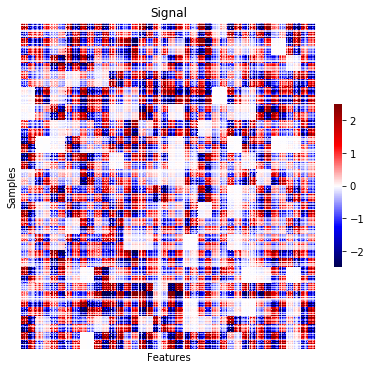

In [38]:
show_signal(true_signal)

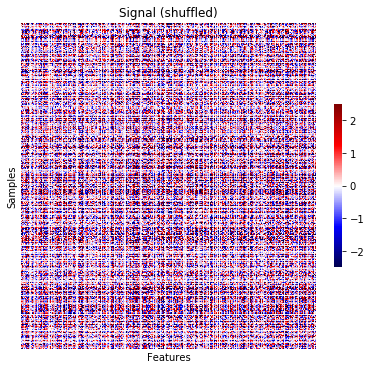

In [39]:
show_signal(true_signal, shuffle=True)

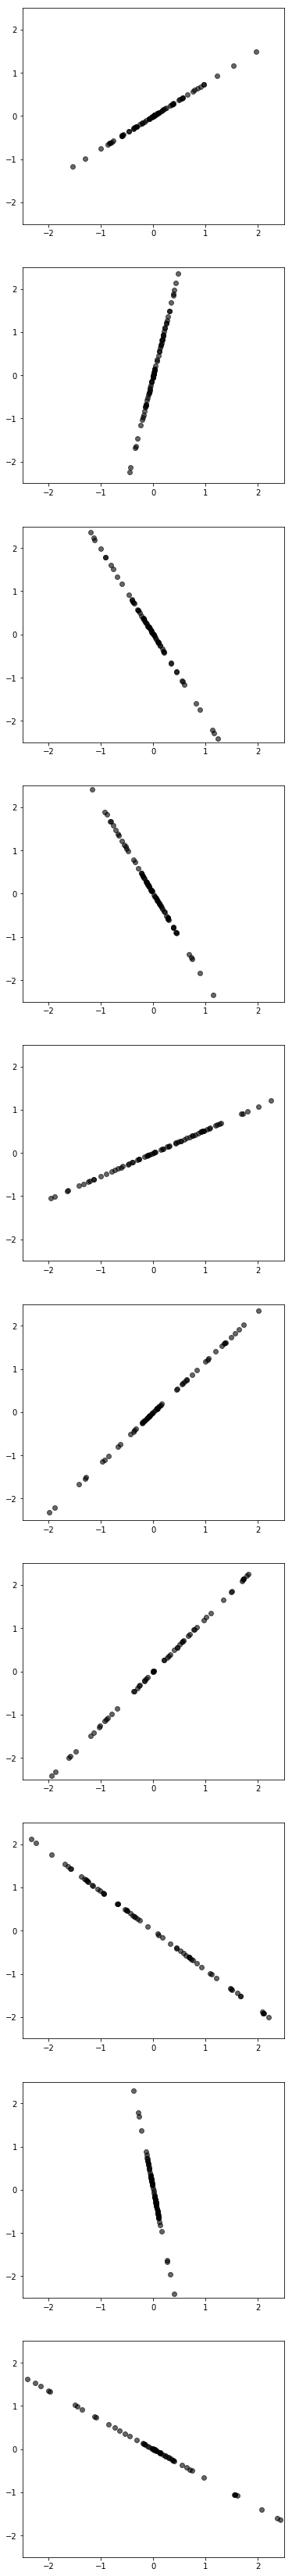

In [62]:
show_dependences(true_signal, true_pairs, 'feature')

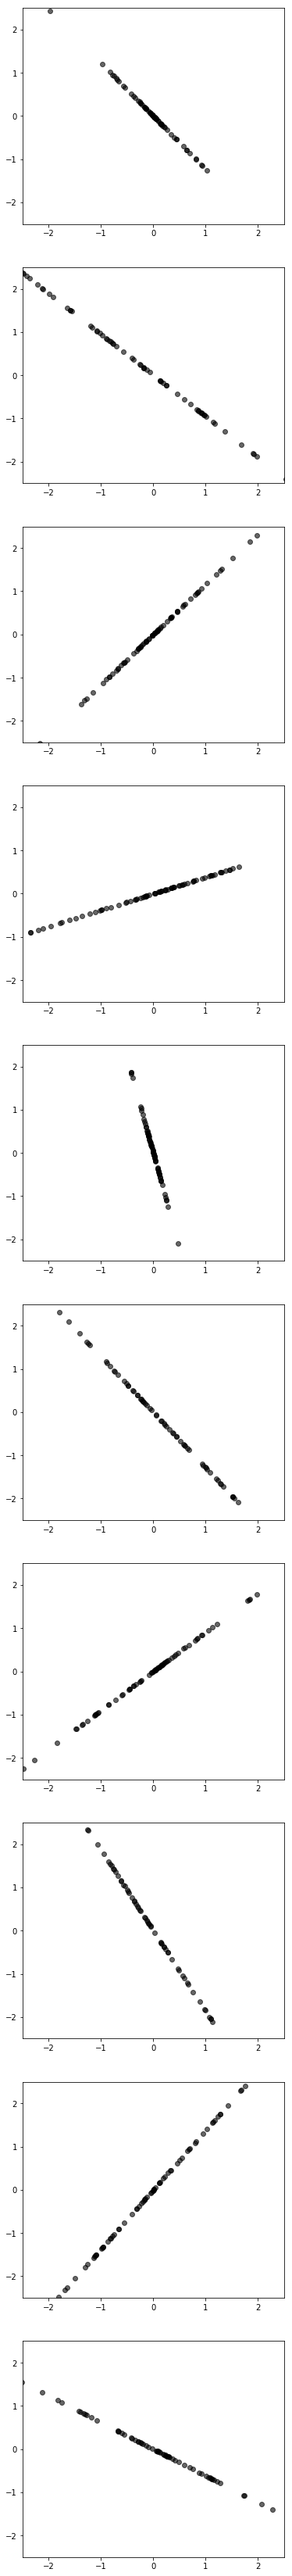

In [63]:
show_dependences(true_signal, true_pairs, 'sample')

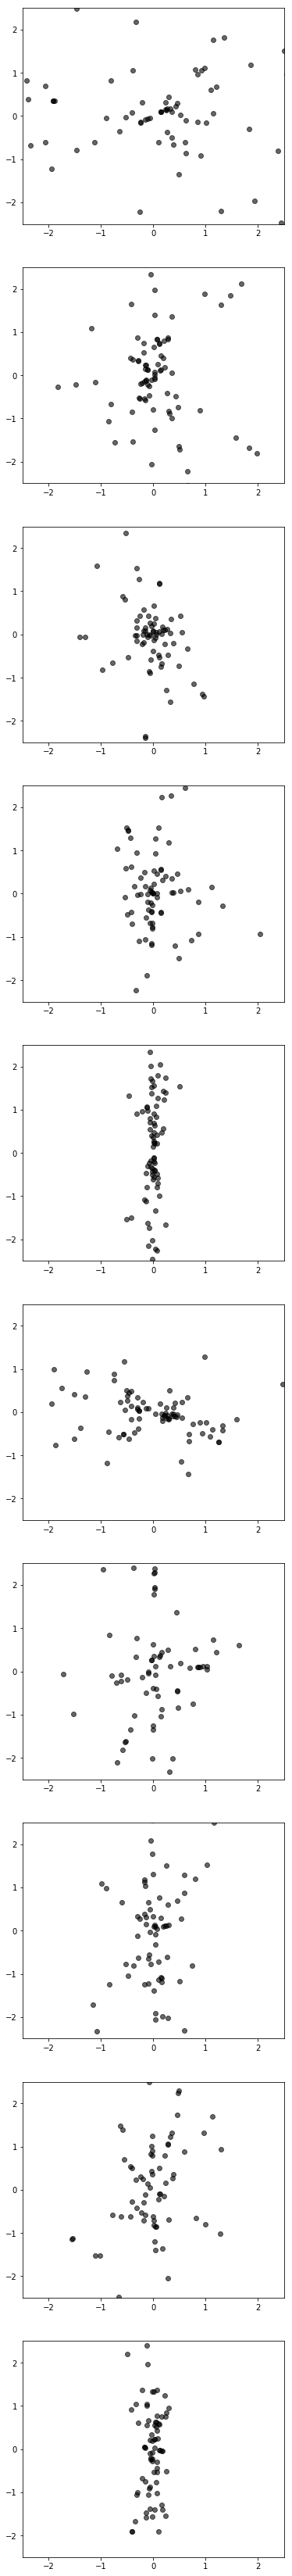

In [64]:
show_independences(true_signal, true_pairs, 'sample')

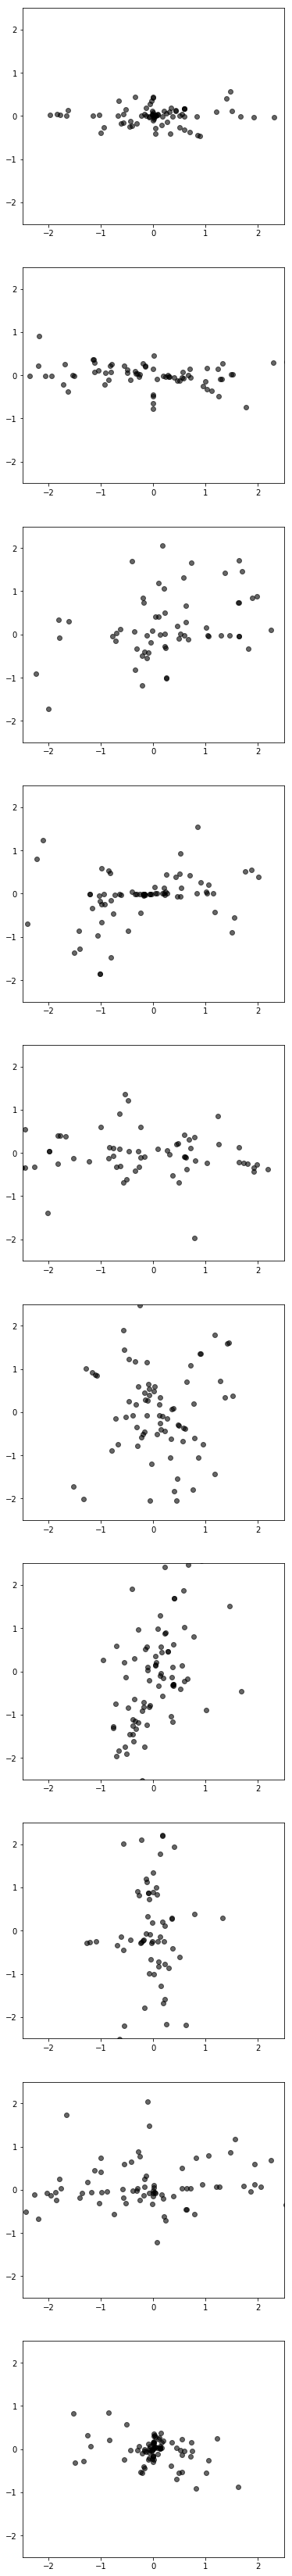

In [65]:
show_independences(true_signal, true_pairs, 'feature')

In [ ]:
signal_characterists = estimate_partial_signal_characterists(mixed, correlation_threshold, true_pairs=true_pairs, true_directions=true_directions, true_stds=true_stds)

In [27]:
# Construct measurements from corrupted signal and its estimated partial characteristics.
operator = LinearOperatorCustom(n_measurements)
measurements = operator.generate(signal_characterists)

In [28]:
# Construct cost function.
cost = Cost(measurements['A'], measurements['y'], sparsity)

In [29]:
# Recover the bias.
solver = ConjugateGradientSolver(mixed, cost.cost_func, guess_func, rank, n_restarts, verbosity=0)
results = solver.recover()

In [30]:
# Recovery performance statistics.
error_cost_func_true_bias = cost.cost_func(truth.d['sample']['true_bias'])
error_cost_func_estimated_bias = cost.cost_func(results['estimated_bias'])
print 'error_cost_func_true_bias', error_cost_func_true_bias
print 'error_cost_func_estimated_bias', error_cost_func_estimated_bias

divisor = np.sum(~np.isnan(mixed))
print 'number of valid values', divisor

mean_absolute_error_true_signal = np.nansum(np.absolute(truth.d['sample']['signal'] - (mixed - truth.d['sample']['true_bias']))) / divisor
mean_absolute_error_estimated_signal = np.nansum(np.absolute(truth.d['sample']['signal'] - results['estimated_signal'])) / divisor
print 'mean_absolute_error_true_signal', mean_absolute_error_true_signal
print 'mean_absolute_error_estimated_signal', mean_absolute_error_estimated_signal

mean_absolute_error_zeros = np.nansum(np.absolute(truth.d['sample']['signal'] - mixed)) / divisor
print 'mean_absolute_error_zeros', mean_absolute_error_zeros

ratio_estimated_signal_to_zeros = mean_absolute_error_estimated_signal / mean_absolute_error_zeros
print 'ratio_estimated_signal_to_zeros', ratio_estimated_signal_to_zeros
    

error_cost_func_true_bias 2.903330946458054e-14
error_cost_func_estimated_bias 1.5002761437752586e-14
number of valid values 9900
mean_absolute_error_true_signal 1.1902699995658742e-17
mean_absolute_error_estimated_signal 6.798776909820044e-08
mean_absolute_error_zeros 0.187283140416693
ratio_estimated_signal_to_zeros 3.6302129997890897e-07
